<center><a href="https://5loi.com/about_loi"><img src="images/DLI_Header.png" width="400" height="186" /></a></center>

# 5a. 使用预训练的模型

虽然通常必须要有一个标注良好的大型数据集才能训练出一个好的深度学习模型，但也有很多“开箱即用”的免费预训练模型供我们使用。在您决定开展自己的深度学习项目时，建议您先从在线查找能够帮助您实现目标的现有模型开始。[NGC](https://ngc.nvidia.com/catalog/models) 是一个提供可用模型的出色平台。GitHub 上也有很多模型，您可以通过在网上搜索来查找这些模型。

## 5a.1 目标

完成本节内容的学习后，您将能够：
* 使用 TorchVision 加载经过良好训练的预训练模型
* 对您自己的图像进行预处理，使其适用于预训练模型
* 使用预训练模型对您自己的图像进行精确推理

In [1]:
import torch
import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io

import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 5a.2 自动化的狗门

在本练习中，我们将创建一个只允许狗进出的狗门，而将猫留在屋内，其他动物则只能在屋外待在它们应该待的地方。通常，我们需要一个非常大的数据集，其中要包含很多狗以及其他动物的图片。所幸，我们可以找到现成的模型，它们已被包含大量动物图片的大型数据集训练过了。

[ImageNet](https://en.wikipedia.org/wiki/ImageNet#History_of_the_ImageNet_challenge) 挑战赛已产生许多可用于图像分类的顶尖模型。这些模型均使用数百万张图像进行了训练，能够准确地将图像分类为 1000 种不同的物体，其中很多类别属于动物，包括多个品种的狗和猫。这些都是适用于狗门的理想模型。

## 5a.3 加载模型

我们先来下载模型。经过训练的 ImageNet 模型可以直接从 TorchVision 库中下载。您可在 [此处](https://keras.io/api/applications/#available-models) 看到可用的模型及其详情。其中任何模型都适用于我们的练习。我们将选取常用模型 [VGG16](https://pytorch.org/vision/stable/models/vgg.html) 的[默认参数](https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg19.html#torchvision.models.VGG19_Weights)

In [2]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

# load the VGG16 network *pre-trained* on the ImageNet dataset
weights = VGG16_Weights.DEFAULT
model = vgg16(weights=weights)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 214MB/s] 


此模型现已加载完毕，我们来观察一下。您会注意到，它看起来很像手语练习中的卷积模型。请注意第一层（输入层）和最后一层（输出层）。和先前的练习一样，我们需要确保图像与模型预期的输入维度相匹配。另外，了解模型将从最后的输出层中返回何种结果也非常有用。

In [3]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 5a.3.1 输入维度

与之前的练习一样，我们的图像应该匹配模型期望的输入维度。由于 PyTorch 模型是动态构建的，模型本身并不知道它的输入形状应该是什么。幸运的是，预训练的 `weights` 自带了它们自己的变换。

In [4]:
pre_trans = weights.transforms()
pre_trans

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

这就相当于下面这段代码：

```Python
IMG_WIDTH, IMG_HEIGHT = (224, 224)

pre_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0, 1]
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    transforms.CenterCrop(224)
])
```

这里有一个新的变换是 [Normalize](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)，它将根据提供的[均值](https://en.wikipedia.org/wiki/Mean)和[标准差](https://en.wikipedia.org/wiki/Standard_deviation)重新着色图像。另一个新的变换是 [CenterCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.CenterCrop.html#torchvision.transforms.v2.CenterCrop)，它会移除图像的边缘。我们可以将这些变换应用到任何我们想要用于 VGG16 模型的图像张量上。

### 5a.3.2 输出维度

我们还可看到，模型将返回形状为 1000 的预测。要记得，在第一个练习中，模型的输出形状为 10，对应于 10 个不同数字。在第二个练习中，形状为 24，对应于手语字母表中的 24 个字母，而这些字母可以在静止图像中捕获。而在本练习中，该图像将放入 1000 种可能的类别中。虽然完整的 ImageNet 数据集包含 20000 多个类别，但该竞赛以及最终产生的预训练模型仅会使用其中 1000 个类别。我们可以在此处看一下所有 [可能的类别](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)。

其中很多类别均为动物，包括各个种类的狗和猫。狗的类别范围是 151 到 268。猫的类别范围是 281 到 285。我们将能使用这些类别告知狗门哪类动物在门口，以及我们是否应该让它进来。

## 5a.4 加载图像
和先前练习中的操作一样，我们首先加载图像并将其显示出来。

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

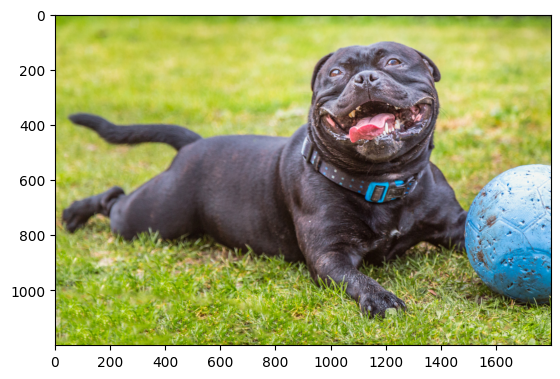

In [6]:
show_image("data/doggy_door_images/happy_dog.jpg")

### 5a.4.1 预处理图像

接下来，我们需要对图像进行预处理，以便能以适当的格式将其送入模型中。这与上一个练习中预测手语图像时的操作类似。要记得，本例中的图像的最终形状需为 (1, 3, 224, 224)。我们将适用 `weights` 的 Transform 方法来做。

In [7]:
def load_and_process_image(file_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(file_path).shape)
    
    image = tv_io.read_image(file_path).to(device)
    image = pre_trans(image)  # weights.transforms()
    image = image.unsqueeze(0)  # Turn into a batch
    return image

让我们在 happy dog 照片上用一下看看效果：

In [8]:
processed_image = load_and_process_image("data/doggy_door_images/happy_dog.jpg")
print("Processed image shape: ", processed_image.shape)

Original image shape:  (1200, 1800, 3)
Processed image shape:  torch.Size([1, 3, 224, 224])


现在维度对了，但变成什么样子了？打印出来看看：

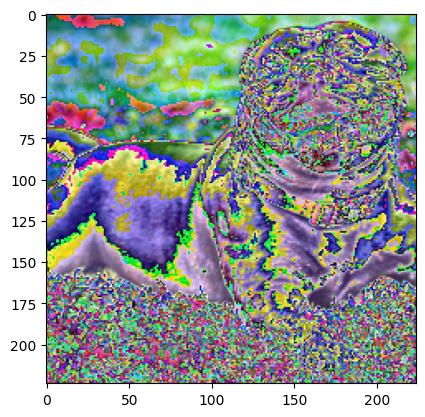

In [9]:
import torchvision.transforms.functional as F

plot_image = F.to_pil_image(torch.squeeze(processed_image))
plt.imshow(plot_image, cmap='gray')

看起来可能有点迷幻，但如果我们眯起眼睛，就还能看出我们的 happy dog。奇怪的着色是 `Normalize` 变换造成的，而照片看起来有点放大是因为 `CenterCrop`。

## 5a.5 进行预测

现在我们已将图像处理成正确的格式，接着我们就可将其传入模型并获取预测。我们预期会输出一个包含 1000 个元素的数组，这读起来不太容易。所幸我们有一个 [json](https://www.json.org/json-en.html) 格式的所有类别列表，它类似于 Python 列表和字典的组合。事实上，让我们将它加载到列表和字典的组合中。

In [10]:
vgg_classes = json.load(open("data/imagenet_class_index.json"))

这个文件使用数字字符串标识每个类别：

In [11]:
vgg_classes["0"]

['n01440764', 'tench']

让我们创建一个函数,使 VGG 模型的预测变得人类可读。这类似于我们上一节的 `predict_letter` 函数。这次，我们将使用 [torch.topk](https://pytorch.org/docs/stable/generated/torch.topk.html) 函数给出前3个预测。

In [12]:
def readable_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    output = model(image)[0]  # Unbatch
    predictions = torch.topk(output, 3)
    indices = predictions.indices.tolist()
    # Print predictions in readable form
    out_str = "Top results: "
    pred_classes = [vgg_classes[str(idx)][1] for idx in indices]
    out_str += ", ".join(pred_classes)
    print(out_str)

    return predictions

请尝试对一些动物进行预测，并查看结果！另外，您还可随时上传自己的图像并对它们进行分类。您可能会对此模型的出色程度感到吃惊。

Original image shape:  (1200, 1800, 3)
Top results: Staffordshire_bullterrier, American_Staffordshire_terrier, Labrador_retriever


torch.return_types.topk(
values=tensor([18.0686, 14.9192, 12.9839], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([179, 180, 208], device='cuda:0'))

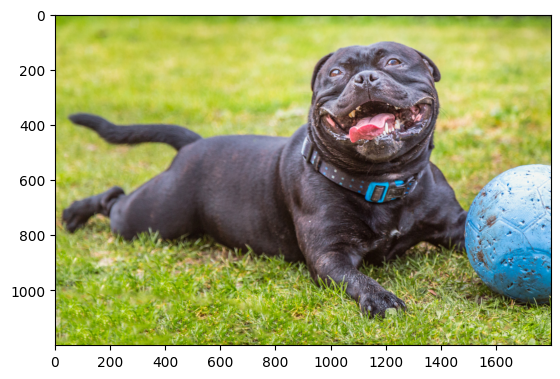

In [13]:
readable_prediction("data/doggy_door_images/happy_dog.jpg")

Original image shape:  (2592, 3456, 3)
Top results: brown_bear, American_black_bear, sloth_bear


torch.return_types.topk(
values=tensor([41.1212, 34.4943, 28.2976], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([294, 295, 297], device='cuda:0'))

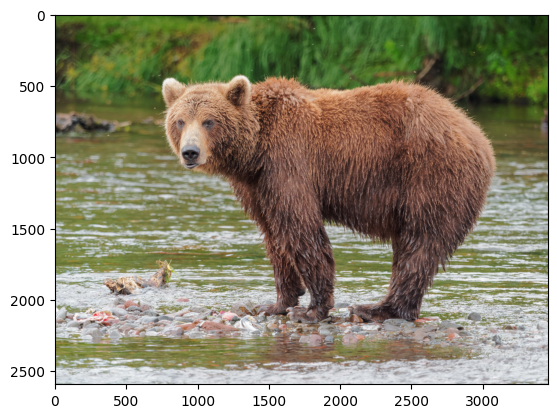

In [14]:
readable_prediction("data/doggy_door_images/brown_bear.jpg")

Original image shape:  (1200, 1800, 3)
Top results: tiger_cat, tabby, hamper


torch.return_types.topk(
values=tensor([15.1148, 12.3535, 11.5066], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([282, 281, 588], device='cuda:0'))

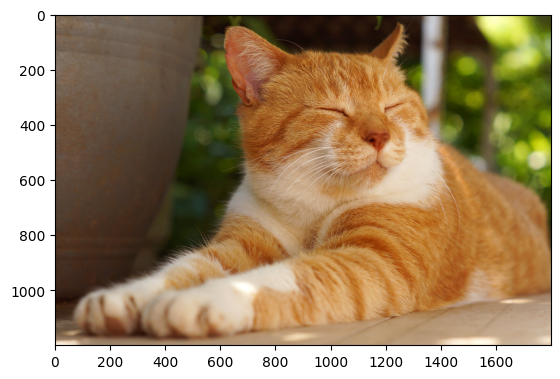

In [15]:
readable_prediction("data/doggy_door_images/sleepy_cat.jpg")

## 5a.6 仅允许狗进出

为了仅允许狗进出并将猫留在屋内，在利用模型进行预测时，我们需要选择合适的类别。狗的类别范围是 151 到 268，而猫的类别范围是 281 到 285。

#### 练习

我们上一节用了 [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) 函数。您还记得我们是从哪个维度提取索引的吗？

**提示**：第一个维度是批次维度。

#### 解答

单击下方的 `...` 查看答案。

In [17]:
# SOLUTION
import numpy as np

def doggy_door(image_path):
    show_image(image_path)
    image = load_and_process_image(image_path)
    idx = model(image).argmax(dim=1).item()
    print("Predicted index:", idx)
    if 151 <= idx <= 268:
        print("Doggy come on in!")
    elif 281 <= idx <= 285:
        print("Kitty stay inside!")
    else:
        print("You're not a dog! Stay outside!")

Original image shape:  (2592, 3456, 3)
Predicted index: 294
You're not a dog! Stay outside!


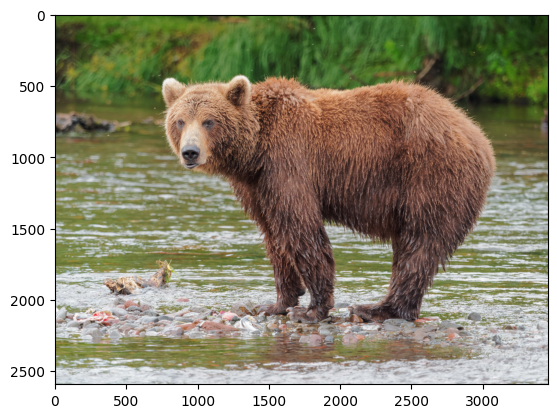

In [18]:
doggy_door("data/doggy_door_images/brown_bear.jpg")

Original image shape:  (1200, 1800, 3)
Predicted index: 179
Doggy come on in!


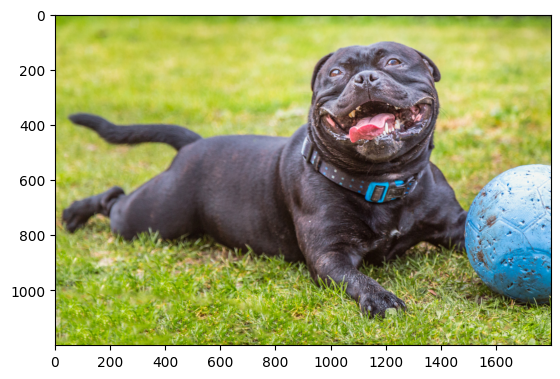

In [19]:
doggy_door("data/doggy_door_images/happy_dog.jpg")

Original image shape:  (1200, 1800, 3)
Predicted index: 282
Kitty stay inside!


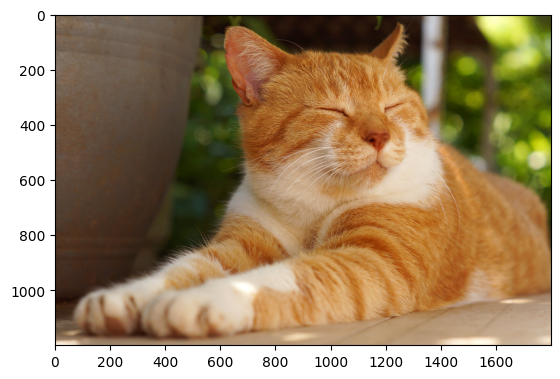

In [20]:
doggy_door("data/doggy_door_images/sleepy_cat.jpg")

## 5a.7 总结

您做得很棒！通过使用强大的预训练模型，我们只用几行代码便创建出了实用的狗门。令人兴奋的是，我们无需做大量的前期工作即可利用深度学习。而且，随着深度学习社区的不断发展，您还可将更多模型用在自己的项目中。

### 5a.7.1 清理显存
继续进行后续内容之前，请执行以下单元清理 GPU 显存。

In [21]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### 5a.7.2 下一步

预训练模型固然非常强大，但其有时也会无法完全适配您的数据。下一节中，您将学习另一项强大技术“*迁移学习*”，它可以帮助您定制预训练模型，进而对您的数据作出良好预测。